In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from scipy import special
from scipy.stats import beta

from conformal_utils import *
from utils.imagenet_helpers import ImageNetHierarchy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/tiffanyding/Desktop/Berkeley/Conformal inference/empirical-bayes-conformal/utils/imagenet_helpers.py:315: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(class_ranges[i].intersection(class_ranges[j])) == 0,


In [2]:
logits = torch.load('data/imagenet_val/logits.pt')
labels = torch.load('data/imagenet_val/labels.pt')

# Convert to Numpy arrays
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()

### Some sanity checks

In [3]:
logits.shape

(50000, 1000)

In [4]:
labels.shape

(50000,)

In [5]:
min(labels), max(labels)

(0, 999)

In [6]:
# Check that there are 50 instances of each class
Counter(labels)

Counter({828: 50,
         800: 50,
         998: 50,
         782: 50,
         570: 50,
         900: 50,
         164: 50,
         776: 50,
         303: 50,
         967: 50,
         81: 50,
         779: 50,
         520: 50,
         441: 50,
         563: 50,
         849: 50,
         197: 50,
         885: 50,
         275: 50,
         615: 50,
         265: 50,
         196: 50,
         826: 50,
         464: 50,
         569: 50,
         131: 50,
         618: 50,
         969: 50,
         578: 50,
         507: 50,
         624: 50,
         510: 50,
         427: 50,
         997: 50,
         455: 50,
         2: 50,
         841: 50,
         866: 50,
         633: 50,
         973: 50,
         18: 50,
         613: 50,
         953: 50,
         202: 50,
         126: 50,
         596: 50,
         774: 50,
         302: 50,
         812: 50,
         96: 50,
         213: 50,
         860: 50,
         711: 50,
         516: 50,
         592: 50,
         314: 5

# Exploratory analysis

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [7]:
alpha = .1

In [8]:
np.random.seed(0)

# Convert logits to softmax vectors
softmax_scores = special.softmax(logits, axis=1)
scores = 1 - softmax_scores

# ======== SHUFFLE AND SPLIT DATA ======== 
num_calib = 25000
idx = np.random.permutation(np.arange(len(labels)))
shuffled_logits = scores[idx]
shuffled_labels = labels[idx]
calib_scores, calib_labels = scores[:num_calib], labels[:num_calib]
val_scores, val_labels = scores[num_calib:], labels[num_calib:]

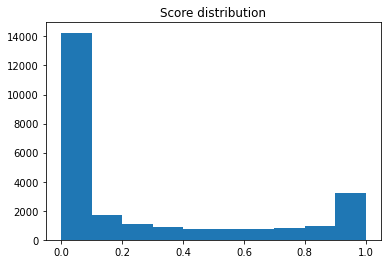

qhat: 0.9504131871128082
Standard conformal inference "marginal coverage": 89.69%


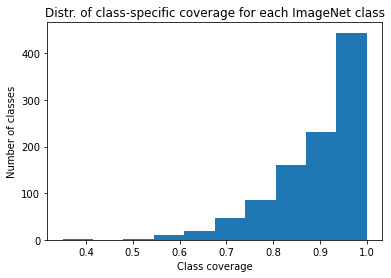

In [9]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference. Another option is to set the quantile to $\infty$

Class-balanced conformal inference "marginal coverage": 92.13%


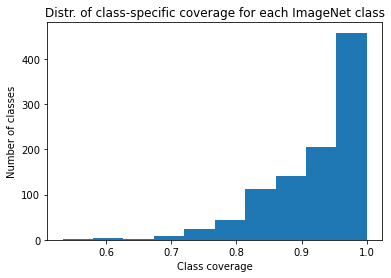

In [10]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = np.inf
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=default_qhat)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(cb_class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

In [11]:
# plt.hist(calib_scores[2])

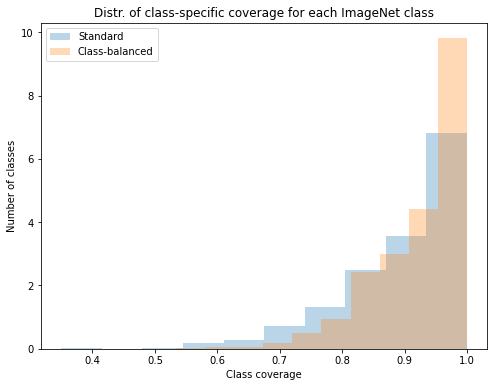

In [12]:
## Plot
plt.figure(figsize=(8,6))

# Combine histograms into one plot
plt.hist(class_specific_cov, label="Standard", alpha=.3, density=True)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3, density=True)

# TODO: Fix this
# # Plot analytical distribution if we assume 
# #  (1) We have an infinite amount of validation data
# #  (2) The calibration set contains an equal number of each class [Note: I'm still working on deriving the distribution when we relax this assumption]
# # (Copied from Anastasios' code in correctness-checks.ipynb, which is linked to in Gentle Intro Section 3)
# n = num_calib / 1000 # This is where Assumption 2 is used
# l = np.floor((n+1)*alpha)
# a = n + 1 - l
# b = l
# rv = beta(a, b)
# x = np.linspace(0.4,1,1000)
# plt.plot(x, rv.pdf(x), lw=3, label=f'Theoretical distribution (assuming equal number of instances of each class)')


# Label plot
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend(loc='upper left')
plt.show()

In [13]:
np.mean(class_specific_cov)

0.8974466535417489

In [14]:
np.mean(cb_class_specific_cov)

0.9220716967787352

In [15]:
class_balanced_ci_preds

[array([396, 716, 728]),
 array([344]),
 array([16]),
 array([170, 199, 203, 600, 633, 716, 728, 792, 799]),
 array([151, 158, 170, 171, 227, 236, 600, 633, 716, 728, 797, 799]),
 array([401, 402, 542, 546, 650, 716, 776, 818, 819]),
 array([162, 164, 170, 539, 633, 716, 728, 799, 811]),
 array([504, 505, 567, 633, 651, 728, 827]),
 array([462, 480, 519, 534, 539, 549, 589, 600, 633, 651, 716, 728, 731,
        771, 784, 789, 792, 797, 799, 811, 818, 827, 830, 840, 882, 894,
        897, 999]),
 array([763, 764]),
 array([365, 381, 600, 728]),
 array([432, 683]),
 array([339, 716, 728]),
 array([354, 728]),
 array([165, 236, 716, 728, 799]),
 array([971]),
 array([617, 728]),
 array([170, 600, 716, 728, 799, 977, 978]),
 array([ 52,  60, 600]),
 array([ 24,  79, 119, 170, 310, 314, 398, 428, 462, 463, 488, 489, 506,
        519, 539, 542, 549, 577, 581, 582, 600, 611, 623, 633, 643, 663,
        677, 716, 728, 733, 741, 784, 787, 792, 797, 799, 818, 825, 858,
        885, 892, 904, 911

In [16]:
standard_ci_preds

[array([396]),
 array([344]),
 array([16]),
 array([203]),
 array([151, 225, 227, 237]),
 array([420, 546, 819]),
 array([162]),
 array([827]),
 array([534, 788, 840, 882, 897]),
 array([763]),
 array([365]),
 array([432]),
 array([339]),
 array([354]),
 array([234, 236]),
 array([971]),
 array([617]),
 array([977]),
 array([52]),
 array([825]),
 array([30]),
 array([448]),
 array([484, 871]),
 array([707, 886]),
 array([348]),
 array([614]),
 array([357]),
 array([351]),
 array([867, 920]),
 array([662]),
 array([247]),
 array([977, 978]),
 array([937, 938]),
 array([619, 846]),
 array([113, 584, 940, 942]),
 array([596, 730]),
 array([513, 875]),
 array([453, 526, 548, 648, 729]),
 array([923, 935]),
 array([39, 46, 47]),
 array([461, 524]),
 array([248, 249, 250]),
 array([298, 299]),
 array([406, 497]),
 array([502, 788]),
 array([594]),
 array([770]),
 array([544, 930]),
 array([594]),
 array([801]),
 array([566]),
 array([ 59, 738, 943, 989, 990]),
 array([379]),
 array([993]),
 

# Save output

We now create an 1000 x 2 array where row i = [# of times class i appears in validation set, # of times class i is included to conformal set prediction when class i is true label]. Note that the second element is equal to (# of times class i appears in validation set)*(observed class coverage under standard conformal inference).

This array will be fed into the `deconvolveR` package to estimate the distribution of class coverage under standard conformal inference

In [17]:
# Count the number of instances of each class in the validation set
class_cts = Counter(val_labels)

# Create array
X = np.zeros((1000,2))
for i in range(len(X)):
    X[i,:] = [class_cts[i], class_cts[i]*cb_class_specific_cov[i]]
    
# Save array
save_to = "data/standard_conformal_class_coverage.csv"
np.savetxt(save_to, X, delimiter=",")
print(f'Saved array to {save_to}')

Saved array to data/standard_conformal_class_coverage.csv


Save the cutoffs (quantiles) for each class, as well as the class-specific coverages. This used to create the json file that I use to create https://observablehq.com/d/5bb27b3940f0bc23

In [18]:
save_to = 'data/class_balanced_qhats.npy'
np.save(save_to, qhats)
print(f'Saved array of qhats to {save_to}')

Saved array of qhats to data/class_balanced_qhats.npy


In [21]:
save_to = 'data/class_specific_coverages.npy'
np.save(save_to, cb_class_specific_cov)
print(f'Saved class-specific coverages to {save_to}')

Saved class-specific coverages to data/class_specific_coverages.npy


## Do semantically similar classes have similar qhats? 

In [23]:
hier_info_path = 'data/imagenet_hierarchy/'
in_hier = ImageNetHierarchy(hier_info_path)

In [32]:
in_hier.get_node("n00001740").descendants_all 

{'n01694178',
 'n02107574',
 'n03187595',
 'n01767661',
 'n02447366',
 'n02112826',
 'n02988304',
 'n01985128',
 'n07716906',
 'n03063338',
 'n01871875',
 'n04209239',
 'n11552386',
 'n03776460',
 'n03134853',
 'n03075370',
 'n01480516',
 'n03918480',
 'n02120079',
 'n01466257',
 'n01796340',
 'n01627424',
 'n03131574',
 'n03485407',
 'n02088094',
 'n02171869',
 'n02008041',
 'n02110063',
 'n02484473',
 'n03636248',
 'n04550184',
 'n02103406',
 'n02895154',
 'n07693725',
 'n01976957',
 'n07720615',
 'n03563967',
 'n02018027',
 'n02992529',
 'n03575240',
 'n03980874',
 'n03691459',
 'n02950826',
 'n03126707',
 'n03617480',
 'n02086346',
 'n03633091',
 'n03891332',
 'n00002137',
 'n01495701',
 'n03380867',
 'n07739506',
 'n02113335',
 'n02104029',
 'n02281787',
 'n03735637',
 'n03792972',
 'n02089973',
 'n01696633',
 'n04183329',
 'n03956157',
 'n01845477',
 'n04208210',
 'n01749939',
 'n02102480',
 'n01824575',
 'n02834397',
 'n04487394',
 'n04517823',
 'n03529860',
 'n02093428',
 'n024

In [ ]:
# def sample_k_dist_neighbor(leaf_node, k):
#     '''
#     Sample uniformly from leaf nodes that are within k steps of leaf_node
    
#     Inputs:
#      leaf_node: Node instance with 0 descendants
#      k: integer >= 1
#     '''
    
#     def is_leaf(node):
#         return node.descendant_count_in == 0
    
#     def get_nodes_within_k(curr_node, k):
#         if k == 0:
#             if is_leaf(curr_node):
#                 leaf_nodes = [curr_node]
#             else:
#                 leaf_nodes = []
#         elif k == 1:
#                 leaf_nodes = get_nodes_within_k()
# #             children = curr_node.children
# #             leaf_nodes = [c for c in children if is_leaf(c)]

#     def get_nodes_within_k(curr_node, k):
#         if k == 0:
#             nodes = [curr_node]
#         elif k == 1:
#             nodes 
        
            
#     leaf_nodes = []
#     if k >= 2:
        
PROBABLY EASIER TO COMPUTE DISTANCES https://www.quora.com/Whatll-be-the-best-method-to-find-the-distances-between-every-two-nodes-in-a-node-tree
    
    just check for membership in self.descendants_all
    

In [31]:
[x for x in [2,3,4,5, 2] if x == 2]

[2, 2]